![Logo](data/AA_Logo.png)

In [7]:
import ira
%alphalab dark
from alpha.utils.tick_loaders import load_data

import qlearn as q
from sklearn.base import TransformerMixin, BaseEstimator

%run utils.py

# Simulator
<hr/>

There are two type of backtesters are supported:

 - <font color='orange'>Fast alpha tester</font>:
    - highly optimized backtester works with pandas dataframes
    - used for fast estimating of trading setup and finding optimal parameters set
    - friendly to modern machine learning libraries (sklearn, tensorflow etc)
    
 
 - <font color='orange'>Event driven simulator</font> 
    - works on Level1/2 historical data (stored in KDB/Q or any other storage)
    - emulates limit/market/MOC/LOC/PEG orders
    - takes in account liquidity (based on Level1/2 history) and emulates slippage/partial fills/ etc
    - emulates execution latency by generating random timeout using preset latency distribution
    - track transactions costs for all executions and emulates rebates trading
    - provides sophisticated position micro-management techniques:
     - splitting big order by random chunks
     - opening position by quoting market (untill condition are being fullfilled)
     - using predictive micro models for optimal order size management  
    - <font color='green'>Strategy coded for simulator is ready to run on live/paper trading by design</font>
   

## Fast alpha backtester
<hr class='l2'/>

It was designed as fast trading ideas verification tool. It'bd be better to show research process using simple trading idea and historical data for crypto market.

As idea we could test this intraday mean-revering trading setup (from [here](https://medium.com/geekculture/the-equilibrium-indicator-profiting-from-mean-reversion-ccecb647b988)):

 - When price expansion from it's mean becomes greater than some threshold we expect reversion to mean and open appropriate position
   - i.e. if price > mean + T we open short or if price < mean - T we open long
   - we will test it on hourly bars intraday data
   - try to find optimal parameters using ML technics 
   - play with different risk managements techniques ans select best

As data we will use BTCUSDT intraday data from Binance (we are collecting it in KDB/Q).


In [2]:
d = load_data('BINANCE:BTCUSDT')
d.ticks()['BTCUSDT'].head()

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,ignore
time,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851,True
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000,True
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921,True
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852,True
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338,True


First we need to write standard sklearn predictor. It allows us to apply most of ML libraries (sklearn, tf, etc).
<hr class='l3'/>

In [3]:
@q.signal_generator
class Equilibrium(BaseEstimator):
    """
        - Calculate a simple N-period moving average of the market price.
        - Subtract the current market price from its moving average.
        - Calculate a N-period exponential moving average on the subtracted values.

        The result is the N-period Equilibrium Indicator that we will use to generate mean-reverting signals.
    """
    def __init__(self, period, threshold, smoother='sma'):
        self.period = period
        self.smoother = smoother
        self.threshold = threshold
        
    def fit(self, x, y, **kwargs): return self
    
    def predict(self, x):
        c = x[self.market_info_.column]
        # price extension
        dK = smooth(smooth(c, self.smoother, self.period) - c, 'ema', self.period)
        # signals
        return srows(pd.Series(-1, dK[((dK.shift(2) < +self.threshold) & ((dK.shift(1) < +self.threshold) & (dK > +self.threshold)))].index),
                     pd.Series(+1, dK[((dK.shift(2) > -self.threshold) & ((dK.shift(1) > -self.threshold) & (dK < -self.threshold)))].index))

Now we can use ML gridsearch approach trying to maximize sharpe ratio on period of 2014-2019 (in sample period).

We will try to find best models parameters set (period, and threshold) that would lead to maximal Sharpe on in-sample period.

<hr class='l3'/>

In [4]:
eq = q.gridsearch('Eq', Equilibrium(5, 0.001), 
                  q.ReverseSignalsSharpeScoring(commissions='binance'), 
                  d.ohlc('1h'), 
                  param_grid = q.permutate_params({
                      'period':    urange(3, 48, 1),
                      'threshold': np.arange(0.001, 0.050, 0.001),
                  }), t_range=['2014', '2019'], 
                  ts_splits=3, verbose=False, return_train_score=False, save=False)

Our best models parameters from optimization step:

In [8]:
print(eq.best_params_)

<hr class='l3'/>
Now we can look at estimated cumulative equity curve and returns distribution. 

At the glance distribution's first moment looks negative but from the other side it has fat right tail, that say us that perhaps sometimes model predicted big movements correctly.
<hr class='l3'/>

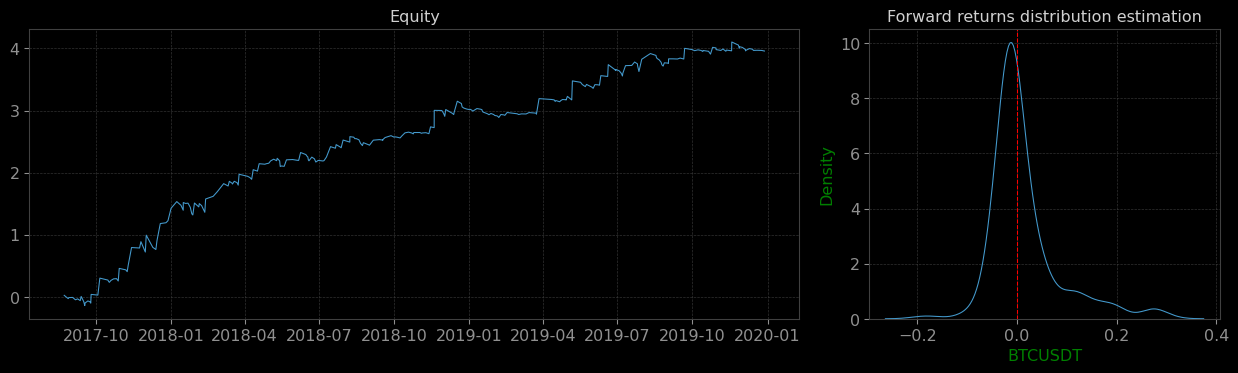

In [9]:
fig(16, 4);
plot_returns_statistics(eq, d.ohlc('1h'), q.ReverseSignalsSharpeScoring(commissions='binance'))

<hr class='l3'/>
Next step is to run fast backtest on found model and test it's entries against different risk management strategies.

There are a set of ready to use classical risk management components but of course it's possible to add own risk management tracker based for example on volatility prediction.

<b>We will test fixed size trading (1000 contracts, 1 contract = 1 USD):</b>
 - fixed take/stop (10% take and 1% risk)
 - trailing ATR technics (known as RAD chandelier indicator)
 - ATR adjusted stop/take levels: take at 3 x ATR, stop at 1 x ATR (1:3 risk ratio)
 - fixed take/stop as at pp. 1 but we will limit maximal position holding by 12 hours (time exit)

In [11]:
eq_r = q.simulation({
    
    # ==> Fixed stop/take: take at 10% and stop at 1%
    'Fixed stop/loss': 
            [eq, q.FixedPctTrader(1000, 0.10, 0.01)],
    
    # ==> Trailing stop on 2 x ATR 
    'Trailing on ATR':
            [eq, q.RADChandelier(1000, '1h', 12, 2)],
    
    # ==> Take/stop is based on ATR and 1:3 risk ratio
    'ATR adjusted stop/take (1:3)': 
            [eq, q.ATRTracker(1000, '1h', 6, 3, 1, 'sma')],
    
    # ==> Fixed stop/take: take at 10% and stop at 1% + forced exit after 12 hours
    'Fixed stop/loss + time exit': 
            [eq, q.PipelineTracker(q.FixedPctTrader(1000, 0.20, 0.20), q.TimeExpirationTracker('12h'))]
    
    }, d.ohlc('1h'), 'binance_um_vip0', 'MeanRevertingCrypto')

 0: MeanRevertingCrypto/Fixed stop/loss               : Sharpe: -inf | Sortino: -0.39 | CAGR: -23.25 | DD: $761.87 (69.80%) | Gain: $-1179.81 | Execs: 934 | Comm: 284.60[inc][OK]
 1: MeanRevertingCrypto/Trailing on ATR               : Sharpe: -inf | Sortino: -3.33 | CAGR: -76.18 | DD: $700.96 (68.15%) | Gain: $-2643.14 | Execs: 827 | Comm: 38.40[inc][OK]
 2: MeanRevertingCrypto/ATR adjusted stop/take (1:3)  : Sharpe: -inf | Sortino: -1.48 | CAGR: -41.61 | DD: $831.60 (71.97%) | Gain: $-1548.53 | Execs: 996 | Comm: 134.80[inc][OK]
 3: MeanRevertingCrypto/Fixed stop/loss + time exit   : Sharpe: 0.95 | Sortino: 1.57 | CAGR: 15.93 | DD: $308.36 (14.04%) | Gain: $1366.74 | Execs: 954 | Comm: 403.40[inc][OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions,comm
0,MeanRevertingCrypto/Fixed stop/loss,-inf,-0.390287,-23.246405,761.869338,69.798982,-1179.814306,934,284.6
1,MeanRevertingCrypto/Trailing on ATR,-inf,-3.329928,-76.177736,700.962931,68.145371,-2643.135878,827,38.4
2,MeanRevertingCrypto/ATR adjusted stop/take (1:3),-inf,-1.475951,-41.613736,831.595849,71.970867,-1548.526299,996,134.8
3,MeanRevertingCrypto/Fixed stop/loss + time exit,0.95313,1.568295,15.926776,308.355077,14.040666,1366.740021,954,403.4


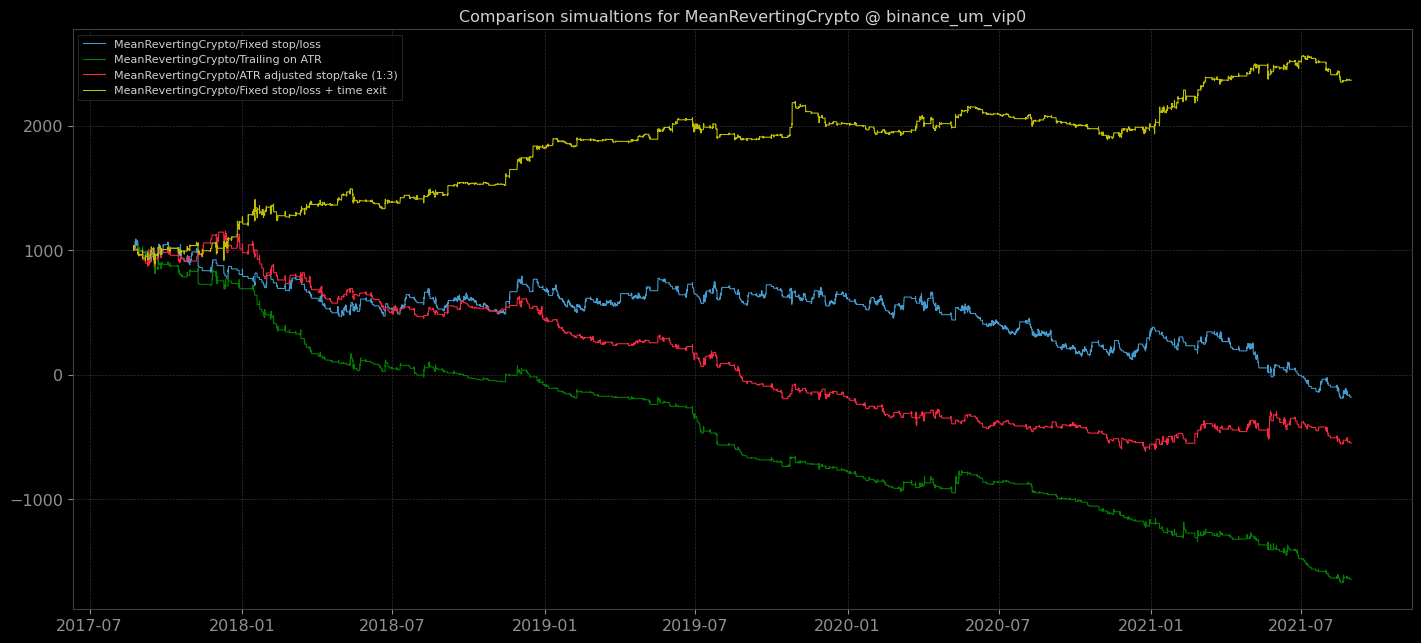

In [12]:
fig(18, 8)
eq_r.report(1000)

<hr class='l3'/>
How we can see from comparison report fixed stop/take tracker is absolute winner in sense of drawdown minimization (and as result led to higher Sharpe). 

We can see now more detailed statistics of this backtest:


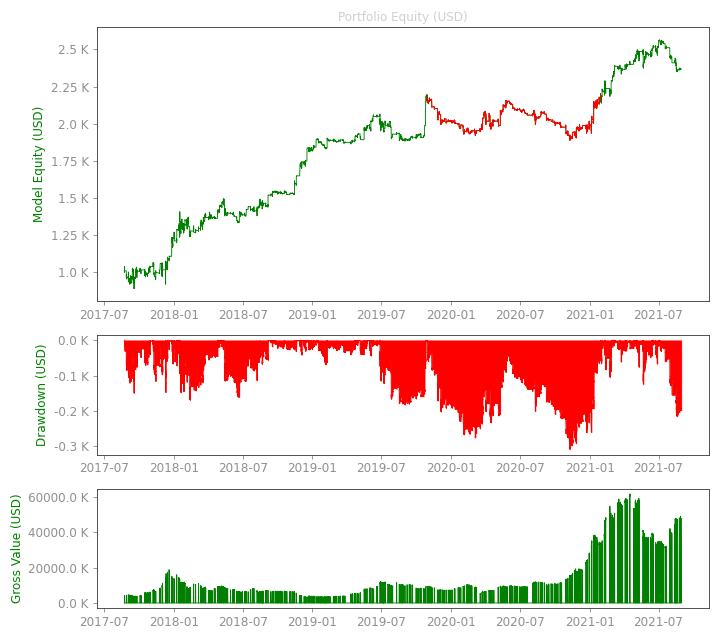

<Figure size 720x640 with 0 Axes>

In [13]:
tearsheet(eq_r.results[3], 1000)

<hr class='l3'/>
<h4> We can controll all steps by looking at execution log:</h4>

In [18]:
executions = eq_r.results[3].executions
executions

,instrument,quantity,exec_price,commissions,comment
2017-08-23 07:59:59,BTCUSDT,1000,4074.88,0.4,
2017-08-23 20:00:00,BTCUSDT,-1000,4117.07,0.4,TimeExpirationTracker:: position 1000 is expired
2017-08-28 05:59:59,BTCUSDT,-1000,4169.01,0.4,
2017-08-28 18:00:00,BTCUSDT,1000,4324.67,0.4,TimeExpirationTracker:: position -1000 is expired
2017-08-28 23:59:59,BTCUSDT,1000,4386.69,0.4,
...,...,...,...,...,...
2021-08-24 15:59:59,BTCUSDT,-1000,48310.74,0.4,
2021-08-25 04:00:00,BTCUSDT,1000,47975.93,0.4,TimeExpirationTracker:: position -1000 is expired
2021-08-27 21:59:59,BTCUSDT,1000,48960.39,0.4,
2021-08-28 10:00:00,BTCUSDT,-1000,48918.65,0.4,TimeExpirationTracker:: position 1000 is expired


And analysing portfolio log with any desired frequency og logging:

In [19]:
eq_r.results[3].portfolio

,BTCUSDT_Pos,BTCUSDT_PnL,BTCUSDT_Price,BTCUSDT_Value,BTCUSDT_Commissions
2017-08-23 07:45:00,0.0,0.000000,4074.88,0.0,0.0
2017-08-23 08:00:00,1000.0,0.000000,4074.88,4074880.0,0.4
2017-08-23 08:45:00,1000.0,12.054343,4124.00,4124000.0,0.0
2017-08-23 09:00:00,1000.0,-0.029449,4123.88,4123880.0,0.0
2017-08-23 09:45:00,1000.0,19.445971,4203.12,4203120.0,0.0
...,...,...,...,...,...
2021-08-30 03:45:00,0.0,0.000000,47964.04,0.0,0.0
2021-08-30 04:00:00,0.0,0.000000,47964.02,0.0,0.0
2021-08-30 04:45:00,0.0,0.000000,47869.02,0.0,0.0
2021-08-30 05:00:00,-1000.0,0.000000,47869.02,-47869020.0,0.4


<hr class='l3'/>
Results looks promising, but of course we'd need to run more additional verifications before running it live. 
<hr class='l3'/>


<p style='font-size:14px; color:orange !important;'>
    This approach allows to build not only classical execution/backtest pipeline but something like 'strategy fabric' that makes it possible to test trading setups in some automatic manner step by step:
    
    - code signal generating rules as component (may be reused in future in other models)
    - analyse forward returns distribution
    - optmize model if need
    - code custom risk management or use ready components
    - backtest model against different risk techniques
    - if backtests look promising code in Java and run on simulator/paper/live
</p>

# Simulator 
<hr class='l2'/>


Last step is to code model in Java and run simulation on historical ticks data.

Usually it's straightforward task and can be done by any senior/mid Java developers.

I'm going to automate even this step when you only will need to provide text based (JSON file) configuration and additional component implementation if needed (this work is still in progress).

Now it works as following:

 1. Using model rules it's needed to code them as Java class. Class must implements some interface from 4 methods:
  - onInit(...) : here you can do some logic when strategy just started
  - onQuote(...): custom logic on new quote (Level1) arrived
  - onTrade(...): custom logic when new trade (TAS) data arrived
  - onFinish(...): any logic on strategy shutdown
  - Additionally it's possible to code custom handlers on order book data updates and orders execution events (rejects, fills, etc)
 2. Provide configuration for this strategy (as JSON file)
 3. Configure simulation setup (historical data source, period of tests, latency etc etc)
 4. Run simulation on dedicated server

<hr class='l3'>
Simulator configuration interface looks like that

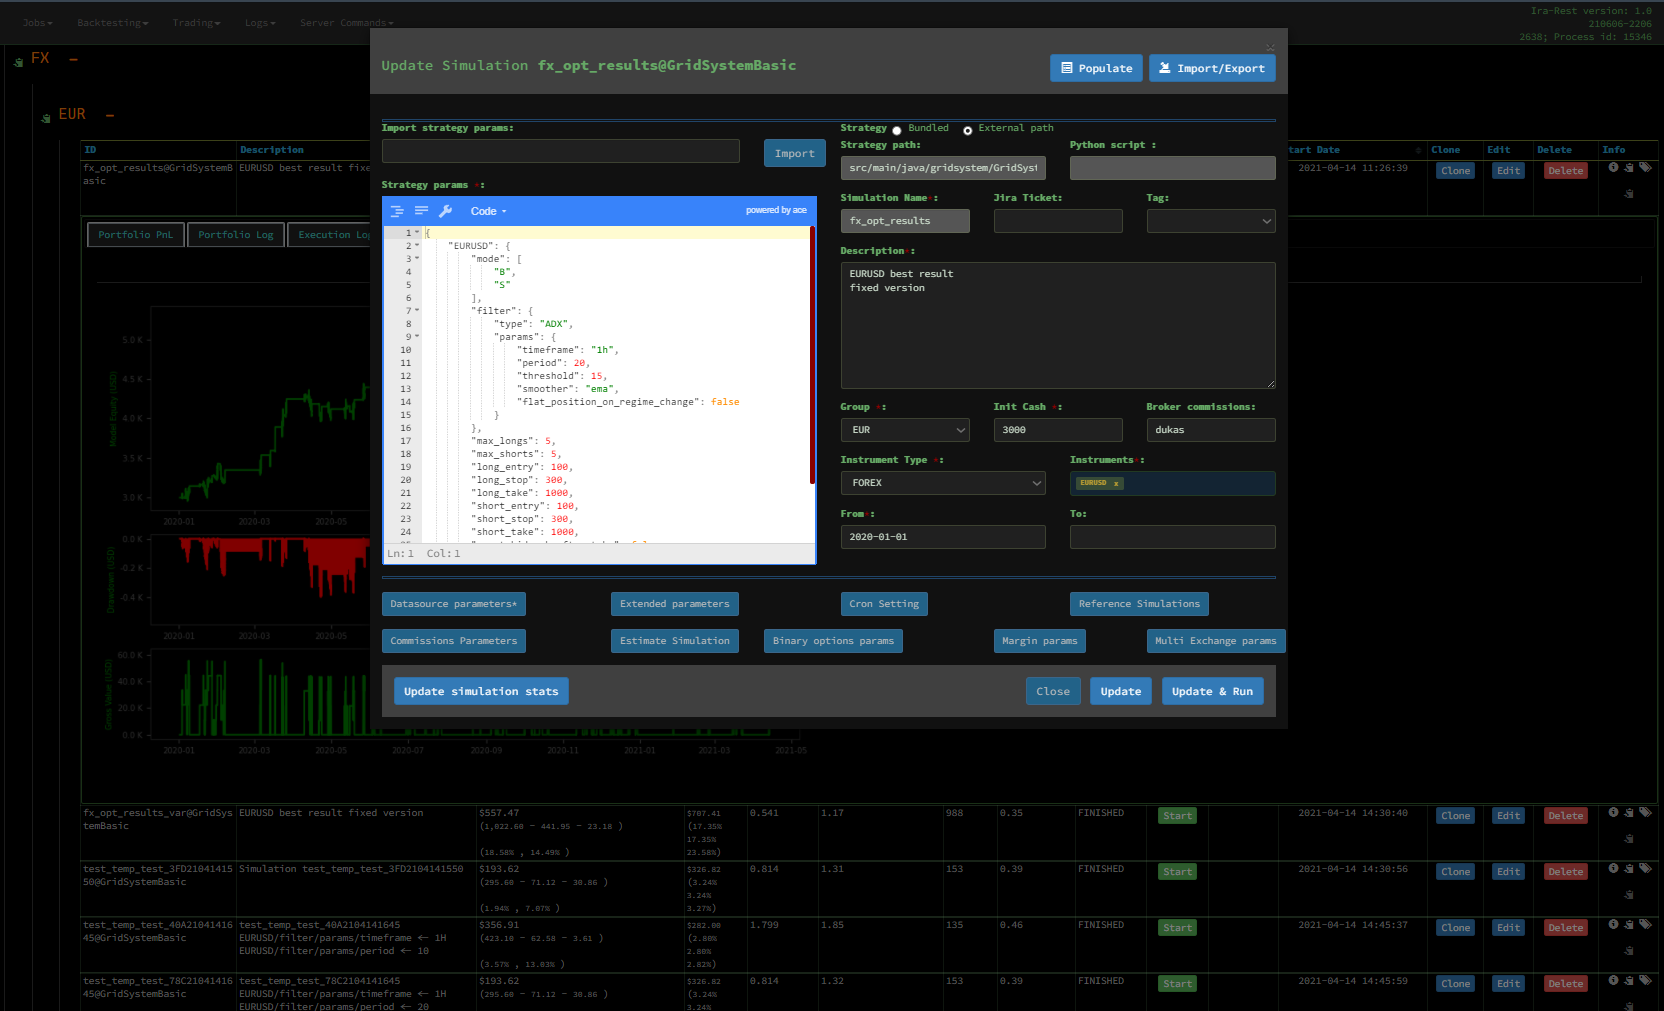

<hr class='l3'>
Simulator runs strategy testing and saves all results into Mongo database. Then it's possible to fetch this data from any Jupyter/Python notebook and do any analysis:

In [67]:
pfl = z_load_sim_portfolio('fx_opt_results@GridSystemBasic', host='saturn')


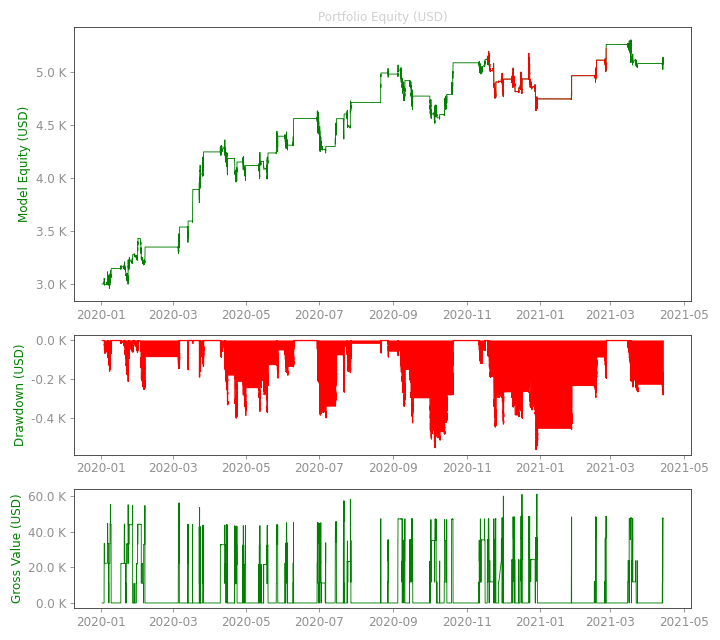

<Figure size 720x640 with 0 Axes>

In [71]:
tearsheet(pfl, 3000)

In [72]:
executions = z_load_sim_executions('fx_opt_results@GridSystemBasic', host='saturn')

In [76]:
executions.head()

,fill_avg_price,creation_time,creation_local_time,submitted_local_time,ask_size,instrument,type,transaction_volume_usd,transaction_realized_pnl_usd,ask_price,...,fill_inc_update_price,fill_inc_update_quantity,bid_size,strategy_id,order_exchange_id,order_id,user_description,bid_price,localtime_quote,status
execution_time,,,,,,,,,,,,,,,,,,,,,
NaT,0.00000,2020-01-03 14:00:00.079,None,None,75000.0,EURUSD,MARKET,0.0,0.0,1.11382,...,0.00000,-0.0,412000.0,fx_opt_results@GridSystemBasic,bed922f7-9ffe-daea-f222-39dacadb8835_exchange_id,bed922f7-9ffe-daea-f222-39dacadb8835,New Short position\nCurrent positions: L: {1=1...,1.11380,2020-01-03 14:00:00.079,SUBMITTED
2020-01-03 14:00:00.079,1.11380,2020-01-03 14:00:00.079,None,None,75000.0,EURUSD,MARKET,11138.0,0.0,1.11382,...,1.11380,-10000.0,412000.0,fx_opt_results@GridSystemBasic,bed922f7-9ffe-daea-f222-39dacadb8835_exchange_id,bed922f7-9ffe-daea-f222-39dacadb8835,New Short position\nCurrent positions: L: {1=1...,1.11380,2020-01-03 14:00:00.079,FILLED
NaT,0.00000,2020-01-03 14:00:00.079,None,None,75000.0,EURUSD,MARKET,0.0,0.0,1.11382,...,0.00000,0.0,412000.0,fx_opt_results@GridSystemBasic,4fafbd33-e8d1-0817-23cb-c8178db65e82_exchange_id,4fafbd33-e8d1-0817-23cb-c8178db65e82,New Long position\nCurrent positions: L: {1=1....,1.11380,2020-01-03 14:00:00.079,SUBMITTED
2020-01-03 14:00:00.079,1.11382,2020-01-03 14:00:00.079,None,None,75000.0,EURUSD,MARKET,11138.2,-0.2,1.11382,...,1.11382,10000.0,412000.0,fx_opt_results@GridSystemBasic,4fafbd33-e8d1-0817-23cb-c8178db65e82_exchange_id,4fafbd33-e8d1-0817-23cb-c8178db65e82,New Long position\nCurrent positions: L: {1=1....,1.11380,2020-01-03 14:00:00.079,FILLED
NaT,0.00000,2020-01-03 14:21:21.822,None,None,64000.0,EURUSD,MARKET,0.0,0.0,1.11482,...,0.00000,0.0,150000.0,fx_opt_results@GridSystemBasic,ca96caca-9445-bd3b-1df2-196588dc3ab8_exchange_id,ca96caca-9445-bd3b-1df2-196588dc3ab8,New Long position\nCurrent positions: L: {1=1....,1.11479,2020-01-03 14:21:21.822,SUBMITTED


<hr class='l3'>
If we consider simulation as successfull we just need to switch this model to live (paper) account and run. 

Live strategy also saves all related data (porfolio tracking, orders executions, logs) into Mongo database and it's also easy to retrieve results of live trading and monitor it in realtime: